# Training mutually independent classifiers
---
This notebook show how to train mutually (linearly) independent classifiers using MSE loss on the linear correlation between classifier outputs. A simple toy dataset is used.

## Initialisation
---
Import the necessary packages.

In [1]:
%matplotlib inline

# Basic import(s)
import os
import sys
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from sklearn.metrics import roc_auc_score
from IPython.display import Image

# Set Keras backend
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Keras import(s)
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.engine.topology import Layer
from keras.utils.vis_utils import plot_model

# TensorFlow import(s)
import tensorflow as tf

# Project import(s)
# -- Add module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    pass
from egamma.utils import *

Using TensorFlow backend.


Define fixed-seed random state, for reproducibility

In [2]:
rng = np.random.RandomState(3)  

Create data arrays for input features and classification targets

In [3]:
# Classes
num_classes  = 2

# Features
num_features = 6
num_features_per_class = num_features // num_classes

# Samples
num_samples_per_class = 5000
num_samples = num_samples_per_class * num_classes

# Distributions widths
widths = np.abs(1. + rng.randn(num_features) * 0.5)

# Correlation matrix
# -- Base matrix
spread = 0.75
corr   = rng.rand(num_features, num_features) * spread + (1. - spread)

# -- Symmetrise
corr += corr.T
corr /= 2.

# -- Unit diagonal
I = np.eye(*corr.shape).astype(bool)
corr[I] = 1

# -- Ensure SPD
good = False
while not good:
    try:
        L = np.linalg.cholesky(corr)
        good = True
    except:
        corr[I] += 0.001
        pass
    pass
corr /= corr[0,0]

# -- Cholesky decomposition
L = np.linalg.cholesky(corr)
Z = rng.randn(num_samples, num_features)  # Standard normals
X = np.inner(Z, L)                        # Non-standard normals

# Get classes
sig = X[:num_samples_per_class, :]
bkg = X[num_samples_per_class:, :]

# Scale up
sig *= widths
bkg *= widths
sig += widths * rng.randn(num_features) * 1.0

# Create arrays (ordered)
X  = np.vstack((sig, bkg))
X1 = np.vstack((sig[:,:num_features_per_class], bkg[:,:num_features_per_class]))
X2 = np.vstack((sig[:,num_features_per_class:], bkg[:,num_features_per_class:]))
y = np.concatenate((np.ones((sig.shape[0],)), np.zeros((bkg.shape[0],))))

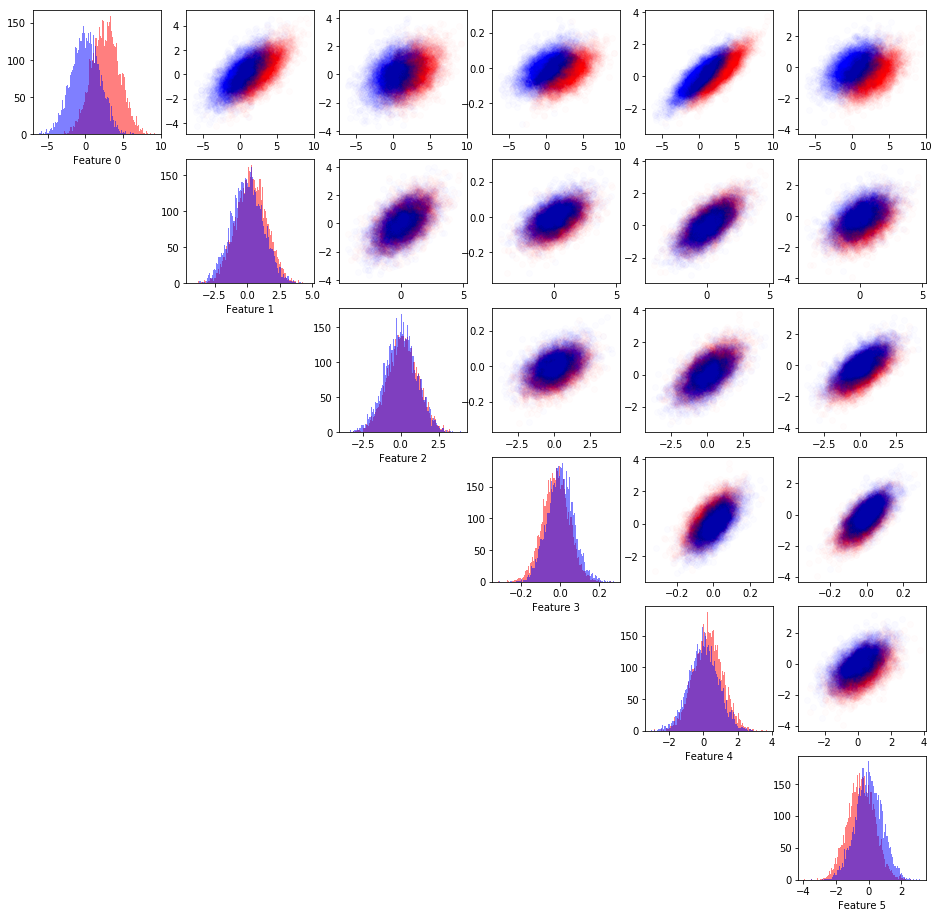

In [4]:
fig, ax = plt.subplots(num_features, num_features, figsize=(16,16))
for i in range(num_features):
    for j in range(num_features):
        if j < i: 
            ax[i][j].axis('off')
            continue
        if i == j:
            ax[i][j].hist(sig[:,i], bins=100,   alpha=0.5, color='red')
            ax[i][j].hist(bkg[:,i], bins=100,   alpha=0.5, color='blue')
            ax[i][j].set_xlabel('Feature {}'.format(i))
        else:
            ax[i][j].scatter(sig[:,i], sig[:,j], alpha=0.01, color='red')
            ax[i][j].scatter(bkg[:,i], bkg[:,j], alpha=0.01, color='blue')
        pass
    pass
plt.show()

### Shuffle, split datasets into training- and test arrays

In [5]:
# Shuffle
idx = np.arange(y.size)
rng.shuffle(idx)

X  = X [idx,:]
X1 = X1[idx,:]
X2 = X2[idx,:]
y  = y [idx]

# Split into training and test
num_train = int(0.8 * y.size)

X1_train = X1[:num_train,:]
X2_train = X2[:num_train,:]
y_train  = y [:num_train]

X1_test = X1[num_train:,:]
X2_test = X2[num_train:,:]
y_test  = y [num_train:]

### Plot covariance matix

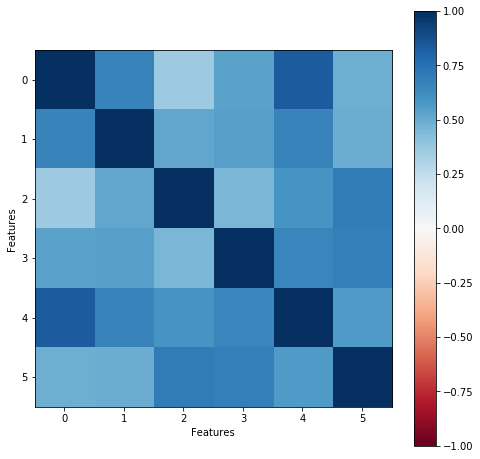

In [6]:
corr_ = np.corrcoef(bkg.T)
fig, ax = plt.subplots(figsize=(8,8))

plt.imshow(corr_, vmin=-1, vmax=1, cmap='RdBu')
plt.xlabel('Features')
plt.ylabel('Features')
plt.colorbar()
plt.show()

## Standalone classifiers
---
Create, compile, and train neural network models

In [7]:
# Network architecture
#arch_clf = [{"units": 16, "activation": "relu"}] * 3

# Create networks
clf1 = classifier_model(num_features_per_class)  #, arch_clf, scope='clf1')
clf2 = classifier_model(num_features_per_class)  #, arch_clf, scope='clf2')

# Compile
clf1.compile(loss='binary_crossentropy', optimizer='adam')
clf2.compile(loss='binary_crossentropy', optimizer='adam')

# Train
ret1 = clf1.fit(X1_train, y_train, shuffle=True, epochs=30, validation_split=0.2, batch_size=128, verbose=0)
ret2 = clf2.fit(X2_train, y_train, shuffle=True, epochs=30, validation_split=0.2, batch_size=128, verbose=0)

### Plot classifier losses

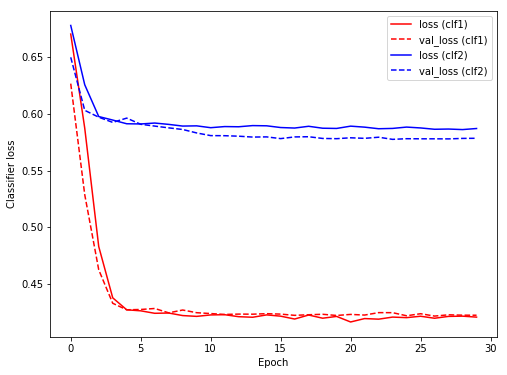

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
colors=['red', 'blue']
linestyles=['-','--',':']
for idx, ret in enumerate([ret1, ret2]):
    for jdx, (name, loss) in enumerate(ret.history.iteritems()):
        plt.plot(loss, color=colors[idx], linestyle=linestyles[jdx], label='{} (clf{})'.format(name, idx + 1))
        pass
    pass
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Classifier loss')
plt.show()

### Plot correlations between classifier predictions  

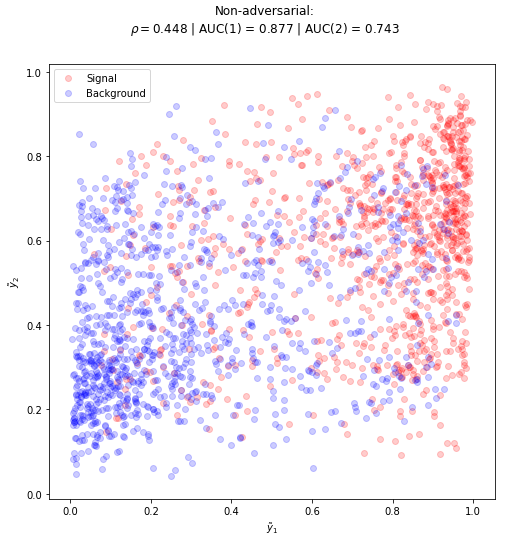

In [9]:
# Get classifier preductions
pred1_test = clf1.predict(X1_test)
pred2_test = clf2.predict(X2_test)

# Compute correlation and ROC AUC
rho = np.corrcoef(np.hstack((pred1_test, pred2_test)).T)[0,1]
auc1 = roc_auc_score(y_test, pred1_test)
auc2 = roc_auc_score(y_test, pred2_test)

# Plot correlation
msk = (y_test == 1)
fig, ax = plt.subplots(figsize=(8,8))
plt.suptitle('Non-adversarial:\n' + r'$\rho = {:.3f}$ | AUC(1) = {:.3f} | AUC(2) = {:.3f}'.format(rho, auc1, auc2))
plt.scatter(pred1_test[ msk], pred2_test[ msk], alpha=0.2, color='red',  label='Signal')
plt.scatter(pred1_test[~msk], pred2_test[~msk], alpha=0.2, color='blue', label='Background')
plt.xlabel(r'$\tilde{y}_{1}$')
plt.ylabel(r'$\tilde{y}_{2}$')
plt.legend()
plt.show()

### Plot classifier distributions

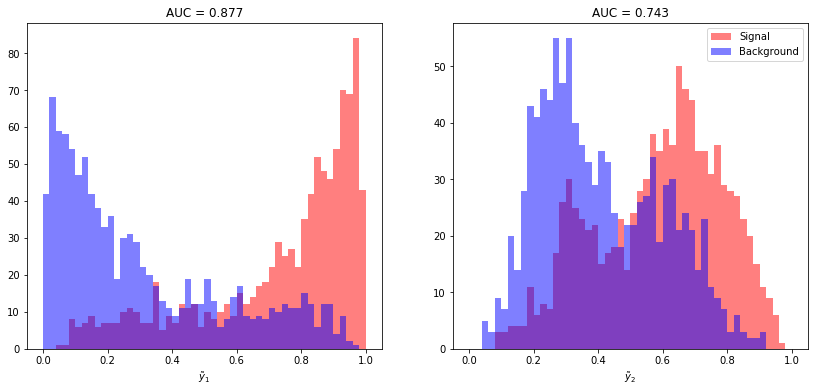

In [10]:
msk = (y_test == 1)
bins = np.linspace(0, 1, 50 + 1, endpoint=True)

fig, ax = plt.subplots(1,2, figsize=(14,6))

# Classifier 1
ax[0].set_title('AUC = {:.3f}'.format(auc1))
ax[0].hist(pred1_test[ msk], bins=bins, alpha=0.5, color='red',  label='Signal')
ax[0].hist(pred1_test[~msk], bins=bins, alpha=0.5, color='blue', label='Background')
ax[0].set_xlabel(r'$\tilde{y}_{1}$')

# Classifier 2
ax[1].set_title('AUC = {:.3f}'.format(auc2))
ax[1].hist(pred2_test[ msk], bins=bins, alpha=0.5, color='red',  label='Signal')
ax[1].hist(pred2_test[~msk], bins=bins, alpha=0.5, color='blue', label='Background')
ax[1].set_xlabel(r'$\tilde{y}_{2}$')

plt.legend()
plt.show()

## Decorrelated classifiers
___

Define custom decorrelation layer.

In [11]:
def correlation_coefficient (x, y):
    """
    Compute the linear correlation coefficient for input arrays `x` and `y` 
    using Keras backend methods.
    """
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return r

class DecorrelationLayer (Layer):
    """
    Custom Keras layer, outputting the linear correlation coefficient for the 
    outputs from the previous layers.
    """
    def __init__ (self, **kwargs):
        super(DecorrelationLayer, self).__init__(**kwargs)
        pass

    def build (self, input_shape):
        return

    def call (self, x, mask=None):
        assert isinstance(x, list)
        assert len(x) == 2
        return correlation_coefficient(*x)

    def compute_output_shape (self, input_shape):
        return input_shape[:1]  # (None,)

    pass



class LossRatioLayer (Layer):
    """
    Custom Keras layer, outputting the ratio of losses of the outputs from the 
    previous layers.
    """
    def __init__ (self, loss, **kwargs):
        super(LossRatioLayer, self).__init__(**kwargs)
        assert isinstance(loss, list)
        assert len(loss) == 2
        self._loss = loss
        pass

    def build (self, input_shape):
        return

    def call (self, x, mask=None):
        assert isinstance(x, list)
        assert len(x) == 4
        # x = [pred_0, pred_1, targetr_0, target_1]
        return K.mean(self._loss[0](K.flatten(x[0]), K.flatten(x[2])) / self._loss[1](K.flatten(x[1]), K.flatten(x[3])))

    def compute_output_shape (self, input_shape):
        return input_shape[:1]  # (None,)

    pass



Define custom `Decorrelator` model.

In [12]:
class Decorrelator (object):

    def __init__ (self, clf1, clf2, lambda_reg=100., beta_reg=10.):
        """
        ...
        """
    
        # Check(s)
        # ...
        
        self._clf1 = clf1
        self._clf2 = clf2
        
        self._lambda = lambda_reg
        self._beta   = beta_reg

        self._targets = None
        self._loss    = None
        self._model   = None
        return
    
    def _build (self):
        """
        ...
        """
        
        # Reconstruct classifier
        input_clf1 = Input(shape=self._clf1.layers[0].input_shape[1:])
        input_clf2 = Input(shape=self._clf2.layers[0].input_shape[1:])
        
        output_clf1 = self._clf1(input_clf1)
        output_clf2 = self._clf2(input_clf2)
        
        # Target inputs, for balancing
        target_clf1 = Input(shape=self._clf1.layers[-1].output_shape[1:])
        target_clf2 = Input(shape=self._clf2.layers[-1].output_shape[1:])
        
        # Add decorrelation layer
        corr = DecorrelationLayer()([output_clf1, output_clf2])
        
        # Add balance layer
        balance = LossRatioLayer(loss=self._loss)([output_clf1, output_clf2, target_clf1, target_clf2])

        # Build model
        self._model = Model(inputs =[input_clf1,  input_clf2, target_clf1, target_clf2],
                            outputs=[output_clf1, output_clf2, corr, balance],
                            name='decorrelator')
        return

    
    def compile (self, loss, **kwargs):
        """
        ...
        """
        
        # Check(s)
        if not isinstance(loss, list):
            loss = list(loss)
            pass
        self._loss = [keras.losses.get(l) for l in loss]

        # Internal build method
        self._build()

        # Compile underlying model
        self._model.compile(loss=self._loss + ['MSE', 'MSE'], loss_weights=[1., 1., self._lambda, self._beta], **kwargs)
        return

    
    def fit (self, inputs, targets, **kwargs):
        """
        ...
        """
        
        # Check(s)
        if not isinstance(targets, list):
            targets = list(targets)
            pass
        self._targets = targets
        self._inputs  = inputs

        # Compute target loss ratio
        # @TODO: Use loss functions!
        print "Evaluating classifiers before fitting."
        loss_num = self._clf1.evaluate(self._inputs[0], self._targets[0])
        loss_den = self._clf2.evaluate(self._inputs[1], self._targets[1])
        loss_ratio = np.ones((self._targets[0].shape[0],)) * loss_num / loss_den
        print "Target loss ratio: {} / {} = {}".format(loss_num, loss_den, loss_ratio[0])
        
        # Actual fit method
        zeros = np.zeros((self._targets[0].shape[0],))
        ret = self._model.fit(self._inputs + self._targets, self._targets + [zeros, loss_ratio], **kwargs)
        
        # Log balancing result
        loss_num = self._clf1.evaluate(self._inputs[0], self._targets[0])
        loss_den = self._clf2.evaluate(self._inputs[1], self._targets[1])
        loss_ratio = loss_num / loss_den
        print "Final loss ratio:  {} / {} = {}".format(loss_num, loss_den, loss_ratio)
        return ret
        
    pass
    

Create `Decorrelator` instance.

In [13]:
decorr = Decorrelator(clf1, clf2, lambda_reg=1.0E+02, beta_reg=1.0E+02)

# Define optimiser.
adam = Adam(lr=1.0E-05)

# Compile
decorr.compile(loss=['binary_crossentropy', 'binary_crossentropy'], optimizer=adam)

Visualise the network models.

In [14]:
mkdir('figures/')
plot_model(clf1, to_file='figures/classifier.png', show_shapes=True)
plot_model(decorr._model, to_file='figures/decorrelator.png', show_shapes=True)

mdkir: Creating output directory:
  figures/


### Classifier model

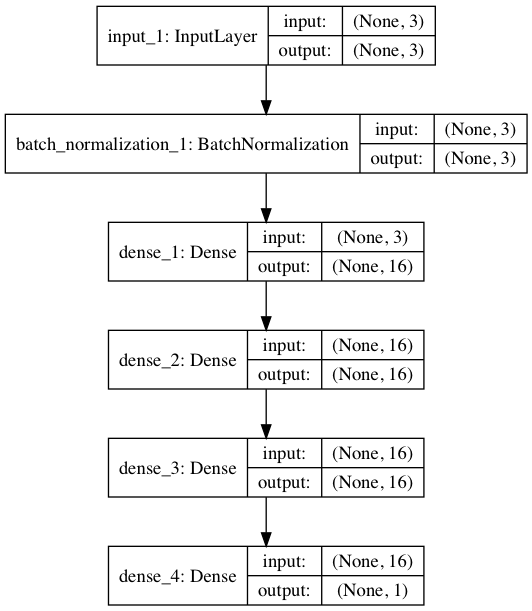

In [15]:
Image(filename='figures/classifier.png')

### `Decorrelator` model

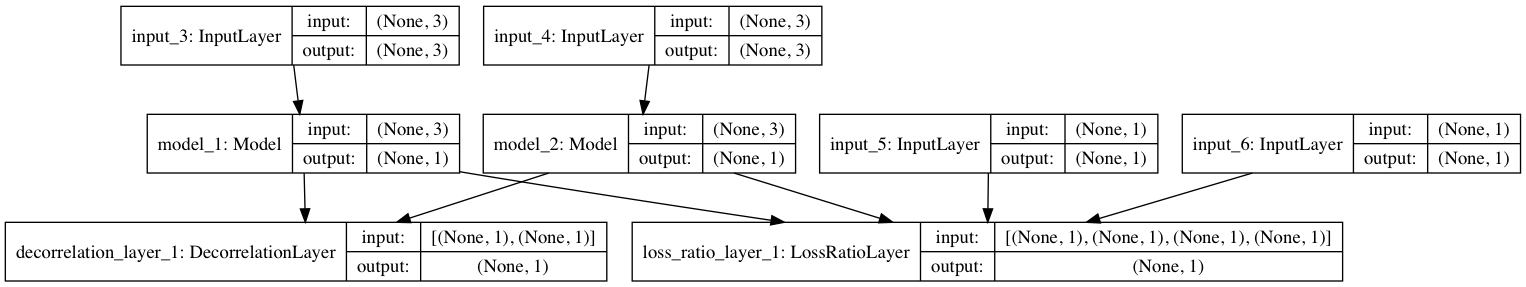

In [16]:
Image(filename='figures/decorrelator.png')

Define optimiser, compile and train `Decorrelator`.

In [17]:
# Fit
ret = decorr.fit([X1_train, X2_train], [y_train, y_train], shuffle=True, epochs=30 * 10, validation_split=0.2, batch_size=128, verbose=0)

Evaluating classifiers before fitting.
8000/8000 [==============================] - 0s 16us/step
Target loss ratio: 0.417262129009 / 0.583043228388 = 0.715662422086
8000/8000 [==============================] - 0s 18us/step
Final loss ratio:  0.461707919955 / 0.6228113662 = 0.741328667092


### Plot `Decorrelator` training loss

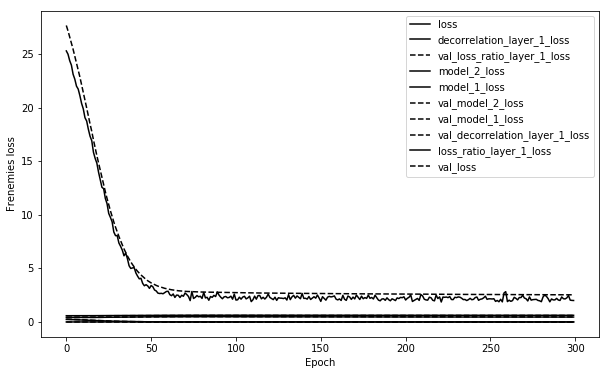

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
for idx, (name, loss) in enumerate(ret.history.iteritems()):
    color='red' if 'clf' in name else ('blue' if 'adv' in name else 'black')
    linestyle='--' if 'val' in name else '-'
    plt.plot(loss, color=color, linestyle=linestyle, label=name)
    pass
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Frenemies loss')
plt.show()

### Plot correlations between classifier predictions

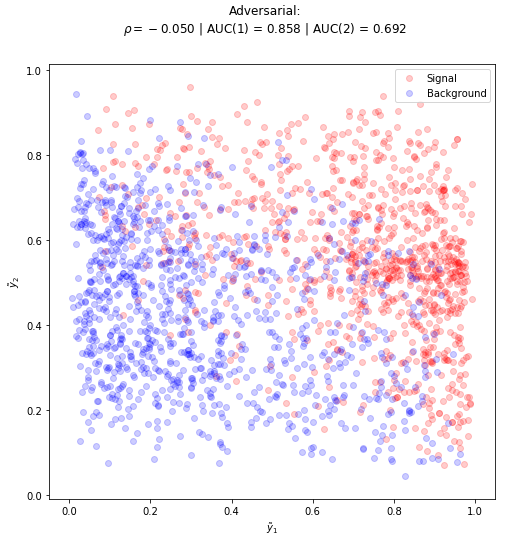

In [19]:
# Get classifier preditions
pred1_test = clf1.predict(X1_test)
pred2_test = clf2.predict(X2_test)

# Compute correlation and ROC AUC
rho = np.corrcoef(np.hstack((pred1_test, pred2_test)).T)[0,1]
auc1 = roc_auc_score(y_test, pred1_test)
auc2 = roc_auc_score(y_test, pred2_test)

# Plot correlation
msk = (y_test == 1)
fig, ax = plt.subplots(figsize=(8,8))
plt.suptitle('Adversarial:\n' + r'$\rho = {:.3f}$ | AUC(1) = {:.3f} | AUC(2) = {:.3f}'.format(rho, auc1, auc2))
plt.scatter(pred1_test[ msk], pred2_test[ msk], alpha=0.2, color='red',  label='Signal')
plt.scatter(pred1_test[~msk], pred2_test[~msk], alpha=0.2, color='blue', label='Background')
plt.xlabel(r'$\tilde{y}_{1}$')
plt.ylabel(r'$\tilde{y}_{2}$')
plt.legend()
plt.show()

### Plot classifier distributions

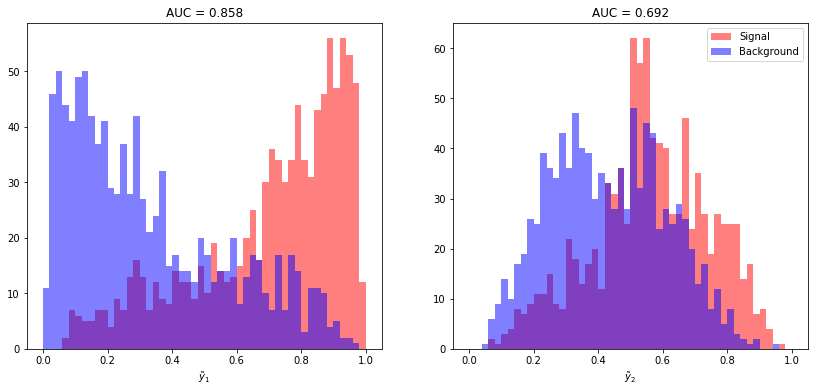

In [20]:
msk = (y_test == 1)
bins = np.linspace(0, 1, 50 + 1, endpoint=True)

fig, ax = plt.subplots(1,2, figsize=(14,6))

# Classifier 1
ax[0].set_title('AUC = {:.3f}'.format(auc1))
ax[0].hist(pred1_test[ msk], bins=bins, alpha=0.5, color='red',  label='Signal')
ax[0].hist(pred1_test[~msk], bins=bins, alpha=0.5, color='blue', label='Background')
ax[0].set_xlabel(r'$\tilde{y}_{1}$')

# Classifier 2
ax[1].set_title('AUC = {:.3f}'.format(auc2))
ax[1].hist(pred2_test[ msk], bins=bins, alpha=0.5, color='red',  label='Signal')
ax[1].hist(pred2_test[~msk], bins=bins, alpha=0.5, color='blue', label='Background')
ax[1].set_xlabel(r'$\tilde{y}_{2}$')

plt.legend()
plt.show()